In [ ]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import itertools

# Uyarıları gizle
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Keras ve TensorFlow
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy

# TensorFlow applications (MobileNet, ResNet vb.)
from tensorflow.keras.applications import MobileNet, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [ ]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [ ]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [ ]:
# ### GPU'nun uygunluğunu kontrol etme
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [ ]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [ ]:
# Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS ,3)

# ### Eğitim ve Doğrulama Örnek Sayıları
train_samples_num = get_files(train_path)
val_samples_num = get_files(valid_path)
print(train_samples_num)
print(val_samples_num)


# Model eğitim ayarları
epochs = 20
train_batch_size = 64
val_batch_size = 64
image_size = 224

# Bir iterasyonda kaç adım gerektiğini bildirme
train_steps = train_samples_num // train_batch_size
val_steps = val_samples_num // val_batch_size



In [ ]:
# Modeli düzenleme

resnet_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
resnet_model.trainable = False


x = resnet_model.output
x = Rescaling(1./255)(x) # Rescaling layer is now imported and can be used
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Yeni çıktılı bir model oluşturma
# Changed densenet_model to resnet_model
model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# Modeldeki yeni katmanların özetine bakma
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,476,935 (101.00 MB)

 Trainable params: 2,889,223 (11.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size, image_size),
                                             batch_size=train_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size, image_size),
                                             batch_size=val_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

test_batches = data_gen.flow_from_directory(valid_path,
                                            target_size=(image_size, image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical'
                                            )


Found 4962 images belonging to 7 classes.
Found 552 images belonging to 7 classes.
Found 552 images belonging to 7 classes.


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli save etmek için checkpoint bildirimi
filepath = "C:/Users/esraa/Desktop/base_dir/resnet_model.keras" # Changed .h5 to .keras

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=2,
                              verbose=1,
                              mode='min',
                              min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]


In [ ]:
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7589 - loss: 1.3958
Epoch 1: loss improved from inf to 1.02425, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/resnet_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 73s 383ms/step - accuracy: 0.7591 - loss: 1.3934 - val_accuracy: 0.8033 - val_loss: 0.7005 - learning_rate: 1.0000e-04
Epoch 2/30
  1/155 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.7500 - loss: 0.8717
Epoch 2: loss improved from 1.02425 to 0.87170, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/resnet_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7500 - loss: 0.8717 - val_accuracy: 0.6250 - val_loss: 1.0196 - learning_rate: 1.0000e-04
Epoch 3/30
154/155 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8055 - loss: 0.6405
Epoch 3: loss improved from 0.87170 to 0.63577, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/resnet_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 60s 379ms/step - accuracy: 0.8055 - loss: 0.6404 - val_accuracy

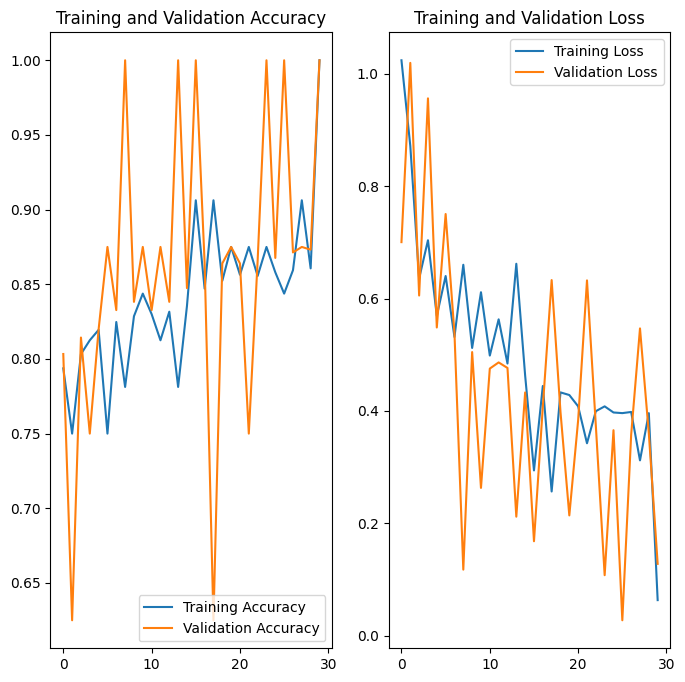

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Modelin tahminlerini al
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=1)
predicted_classes = predictions.argmax(axis=1)

# Hassasiyet, geri çağırma, F1 skor hesaplama
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


In [ ]:
# Model ağırlıklarını yükleme
model.load_weights(filepath)

# Modeli değerlendirme
val_loss, val_acc = model.evaluate(test_batches, steps=val_steps)
print('val_loss:', val_loss)
print('val_cat_acc:', val_acc)


In [ ]:
# Modeli hesaplama
# Son dönümün hesabı
val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


# En iyi dönüm için hesaplama
model.load_weights(filepath)

val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, verbose=1)

In [ ]:
# Confusion matrisi oluşturma
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Confusion matrisini görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.7475 - loss: 0.7140
val_loss: 0.3424907922744751
val_cat_acc: 0.8841911554336548
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step
Normalized Confusion Matrix
[[0.06666667 0.4        0.33333333 0.         0.         0.2
  0.        ]
 [0.         0.72222222 0.05555556 0.         0.05555556 0.16666667
  0.        ]
 [0.         0.04545455 0.70454545 0.         0.         0.25
  0.        ]
 [0.         0.         0.25       0.         0.         0.75
  0.        ]
 [0.         0.04347826 0.30434783 0.         0.17391304 0.47826087
  0.        ]
 [0.         0.         0.01357466 0.         0.00452489 0.98190045
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]]


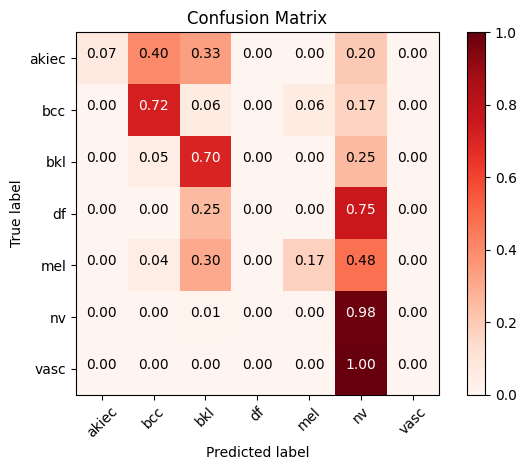

In [ ]:
# Confusion matrisi oluşturan fonksiyon
def plot_confusion_matrix(cm, classes, normalize=True,
                          title='Confusion matris', cmap=plt.cm.Reds):

    #Bu fonksiyon, karışıklık matrisini yazdırır ve çizer. Normalleştirme, 'normalize=True' ayarlanarak uygulanabilir.

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalize edilmiş Confusion matris")
    else:
        print('Normalize edilmemiş Confusion matris')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmini Etiket')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels)

image shape: (224, 224, 3)


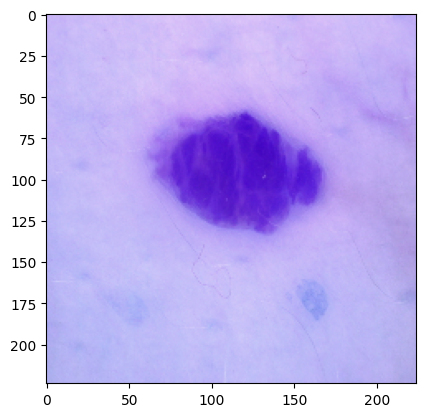

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[[5.0899427e-04 3.3453226e-04 6.6070082e-03 3.6980291e-03 7.8435177e-03
  9.7632730e-01 4.6806736e-03]]
nv


In [ ]:
img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,
                                        saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()
#img_test = img_test/255.

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])

In [ ]:
# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/resnet_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/resnet_model.h5")
